https://www.kaggle.com/nanigans/deep-clustering

## __이미지 클러스터링 (VGG+Kmeans)__
@yejichoi 2022-05-07

In [1]:
import sys  #sys.exit(0)
from collections import Counter
from tqdm import tqdm
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.models import vgg16
from torchsummary import summary # !pip install torchsummary
from sklearn.cluster import KMeans
from sklearn import decomposition

In [3]:
trn_dataset = datasets.MNIST('./mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.Resize(224),
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ])) 

val_dataset = datasets.MNIST("./mnist_data/", 
                             download=True,
                             train=False,
                             transform= transforms.Compose([
                               transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [4]:
trn_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
one_image, label = trn_dataset[0]
one_image.shape

torch.Size([1, 224, 224])

In [8]:
model = vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad_(False)

In [9]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [31]:
num_features = model.classifier[6].in_features
print(num_features)
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 512)]) # Add our layer with 10 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)

4096
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [32]:
kmeans_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=kmeans_clusters, random_state=0)

In [33]:
def extract_features(model, dataset, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size)
    features = []  
    for image, _ in tqdm(loader, desc='extracting features'):
        new_im=torch.Tensor(np.stack((image, image, image),axis=1))
        new_im=torch.squeeze(new_im)
        output = model(Variable(new_im))#.cuda())
        features.append(output.data) #.cpu())
    return torch.cat(features).numpy() 

In [34]:
def cluster(kmeans, model, dataset, batch_size, return_features=False):
    features = extract_features(model, dataset, batch_size)
    pca =  decomposition.PCA(n_components=64).fit(features)
    reduced = pca.fit_transform(features)
    print('pca done')
    print(reduced.shape)
    pseudo_labels = list(kmeans.fit_predict(reduced))
    print('clustering done')
    if return_features:
        return pseudo_labels, features
    return pseudo_labels

In [35]:
val_dataset.targets, val_dataset.targets.shape

(tensor([7, 2, 1,  ..., 4, 5, 6]), torch.Size([10000]))

In [36]:
pseudo_labels, features = cluster(kmeans, model, val_dataset, batch_size=10, return_features=True)

extracting features: 100%|██████████| 1000/1000 [1:18:51<00:00,  4.73s/it]


pca done
(10000, 64)
clustering done


In [37]:
print(np.unique(pseudo_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([1092, 1196, 1326,  742,  683, 1154, 1163,  911, 1058,  675]))


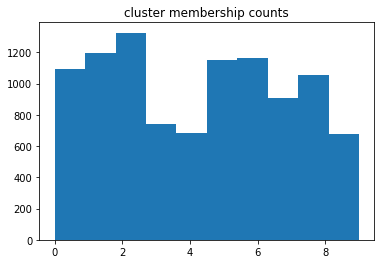

In [38]:
plt.hist(pseudo_labels, bins=kmeans_clusters)
plt.title('cluster membership counts')
plt.show()

In [41]:
def show_cluster(cluster, labels, dataset, limit=32):
    images = []
    labels = np.array(labels)
    indices = np.where(labels==cluster)[0]
    
    if not indices.size:
        print(f'cluster: {cluster} is empty.')
        return None
    
    for i in indices[:limit]:
        image, _ = dataset[i]
        images.append(image)
        
    gridded = make_grid(images)
    plt.figure(figsize=(15, 10))
    plt.title(f'cluster: {cluster}')
    plt.imshow(gridded.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


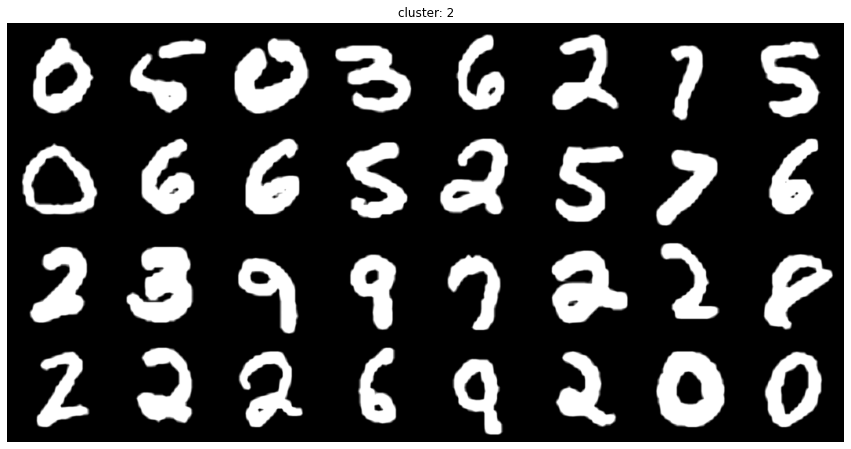

In [42]:
counts = Counter(pseudo_labels)
show_cluster(counts.most_common()[0][0], pseudo_labels, val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


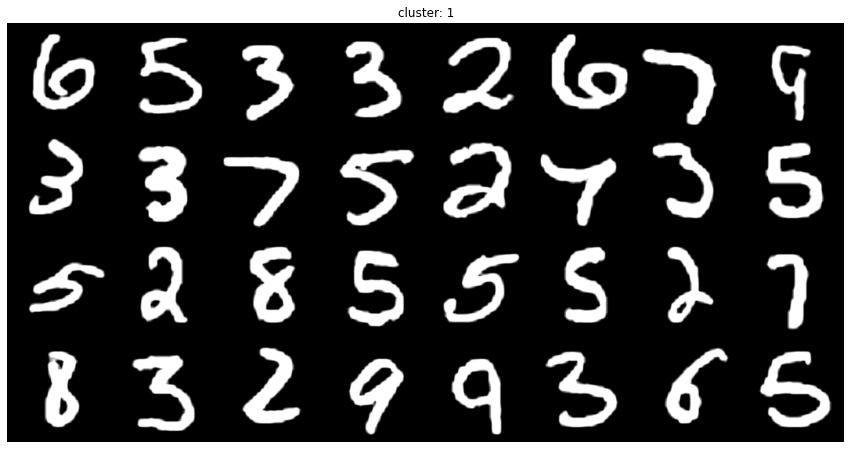

In [43]:
show_cluster(counts.most_common()[1][0], pseudo_labels, val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


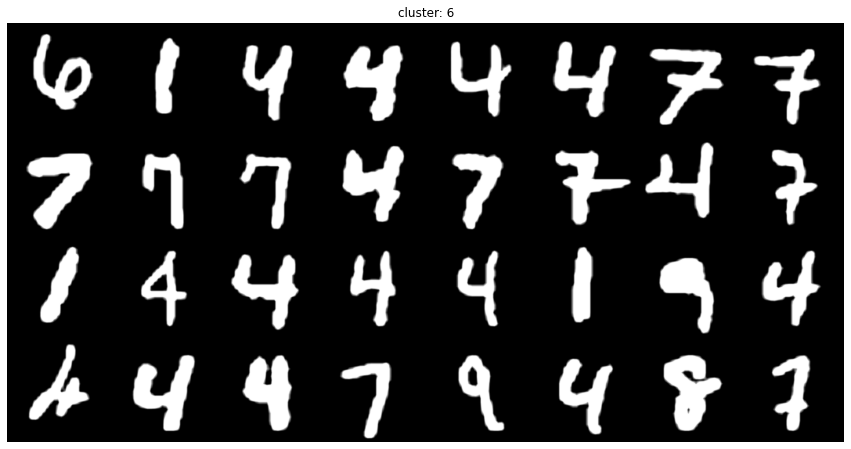

In [44]:
show_cluster(counts.most_common()[2][0], pseudo_labels, val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


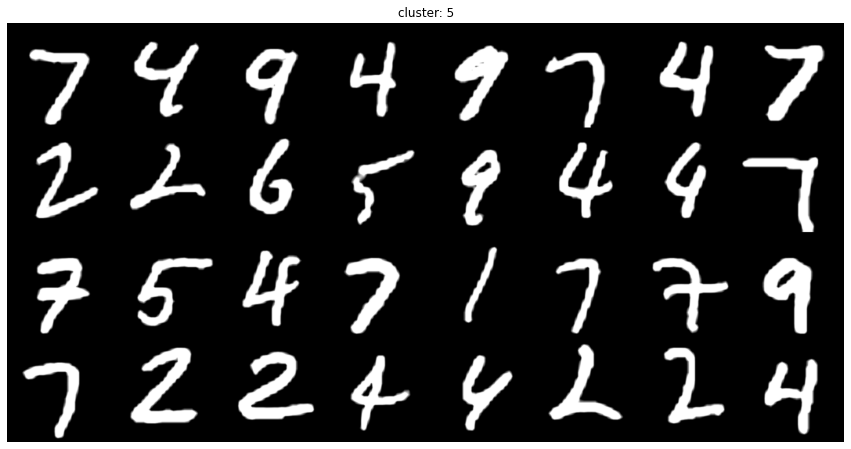

In [45]:
show_cluster(counts.most_common()[3][0], pseudo_labels, val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


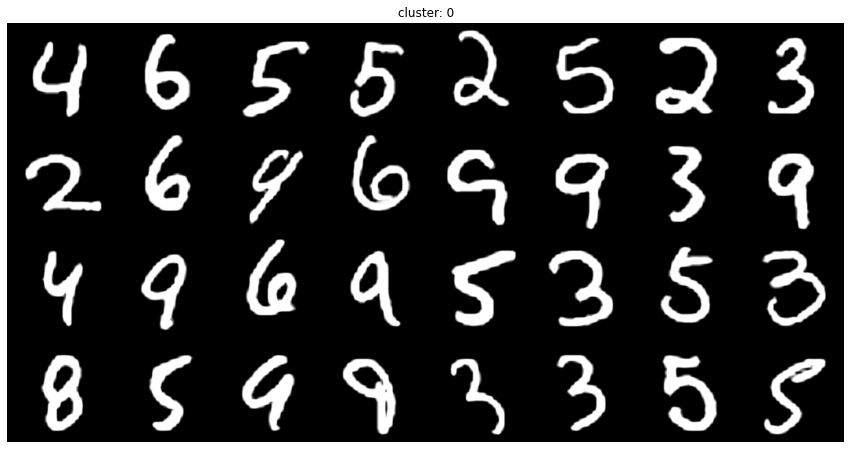

In [46]:
show_cluster(counts.most_common()[4][0], pseudo_labels, val_dataset)